In [1]:
%load_ext autoreload
%autoreload 2
import config
import torch
from app.Classifiers.Classifier_NN import Classifier_IMGNET, Classifier_MNIST
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import scienceplots
plt.style.use(['science', 'ieee'])

from torch import nn
from sklearn.model_selection import train_test_split
from app.NObSP.NObSP_Decomposition import NObSP_NN_single_MultiOutput, NObSP_NN_single_MultiOutput_reg
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader as tf_dataloader
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import os
from tqdm.notebook import tqdm
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [2]:
os.environ['PATH'] = "/Library/TeX/texbin:" + os.environ['PATH']
os.environ['MallocStackLogging'] = 'NO'

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(1, 1))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [5]:
# Cargar los tensores guardados
images = torch.load('images.pth')
X = torch.load('tensors.pth')
X = torch.stack(X) # Convierte 'X' en un tensor si es una lista de listas
X_small = torch.load('tensors_avgpooling.pth')
y = torch.load('labels.pth')
y = torch.tensor(y)  # Convierte 'y' en un tensor si es una lista de enteros
y = torch.nn.functional.one_hot(y, num_classes=1000)

In [6]:
X_sample = []
X_small_sample = []
y_sample = []
index_used = []

sample_size = 400
y_values = [148, 22, 21, 208, 291, 283, 2, 281, 292, 269]

for i in y_values:
    indices = torch.where(y.argmax(dim=1) == i)[0]
    indices = indices[torch.randperm(len(indices))[:sample_size]]
    index_used.append(indices)
    X_sample.append(X[indices])
    X_small_sample.append(X_small[indices])
    y_sample.append(y[indices])

# Verifica que cada tensor en X_sample y y_sample es diferente
for i in range(len(X_sample)):
    for j in range(i + 1, len(X_sample)):
        assert id(X_sample[i]) != id(X_sample[j])
        assert id(y_sample[i]) != id(y_sample[j])

index_used = [tensor.item() for sublist in index_used for tensor in sublist]
images_sample = [images[i] for i in index_used]
X_sample = torch.cat(X_sample)
y_sample = torch.cat(y_sample)
X_small_sample = torch.cat(X_small_sample)

In [7]:
len(images)/10

2000.0

In [8]:
from torchvision.models import resnet18 as model 
from torchvision.models import ResNet18_Weights as model_weights
# Cargar el modelo preentrenado de DenseNet121
weights = model_weights.IMAGENET1K_V1
model = model(weights=weights)
model.eval()  # Poner el modelo en modo de evaluación

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
X_sample.shape

torch.Size([4000, 25088])

In [10]:
class ClassifierSmall(nn.Module):
    def __init__(self, model):
        super(ClassifierSmall, self).__init__()
        self.weights = model.fc.weight.data
        self.classifier = nn.Linear(512, 1000)
        self.classifier.weight.data = self.weights

    def forward(self, x):
        y_lin = self.classifier(x)
        prob = F.softmax(y_lin, dim=1)
        return prob, x, y_lin

classifier_small = ClassifierSmall(model)

In [11]:
classifier_small.eval()  # Setting the model in evaluation mode
with torch.inference_mode():
    y_prob_2, x_trans_total_2, y_est_2 = classifier_small(
        X_small_sample
    )  # Computing the nonlinear transformation of the input data X

In [12]:
if os.path.exists("betas_tensor_small.pth"):
    betas_tensor_small = torch.load("betas_tensor_small.pth")
else:
    betas_tensor_small = NObSP_NN_single_MultiOutput_reg(
        X_small_sample, y_est_2, classifier_small
    )  # Computing the decomposition using NObSP. The Alpha parameters are the weigths for the Interpretation Layer
    torch.save(betas_tensor_small, "betas_tensor_small.pth")

In [13]:
def get_contrib(X, model, betas):
    X_new = X.clone()
    
    with torch.inference_mode():
        clase = torch.argmax(model(X_new.unsqueeze(0))[0].detach())
        
    X_target_tot = torch.zeros((1, list(model.children())[-1].in_features))

    X_temp = X_new.repeat(len(X_new), 1)
    X_temp = torch.eye(len(X_new)) * X_temp
    with torch.inference_mode():
        _, X_latent, _ = model(X_new.unsqueeze(0))
        _, X_target, _ = model(X_temp)
    X_target_tot = torch.cat((X_target_tot, X_target), 0)
    X_target_tot = X_target_tot[1:]

    contrib = (X_target_tot @ betas[:, :, clase]).diag()
    return clase, contrib, X_latent

In [14]:
def train_contribs(X, model, betas, index_used):
    contribs = []
    labels = []
    tensors = []
    latents = []
    for i in tqdm(range(len(X))):
        label, contrib, latent = get_contrib(X[i], model, betas)
        contribs.append(contrib.numpy())
        labels.append(label)
        tensors.append(X[i].numpy())
        latents.append(latent.numpy()[0])

    train_contribs = pd.DataFrame(
        {
            'Contrib': contribs,
            'Label': labels,
            'Flatten': tensors,
            'Latent': latents,
            'Images_index': index_used
        }
    )
    return train_contribs

In [15]:
if os.path.exists("train_contribs.pkl"):
    train_contribs = pd.read_pickle("train_contribs.pkl")
    images_sample = [images[i] for i in train_contribs['Images_index']]
else: 
    train_contribs = train_contribs(X_small_sample, classifier_small, betas_tensor_small, index_used)
    train_contribs.to_pickle("train_contribs.pkl")
    
train_contribs.head()

,Contrib,Label,Flatten,Latent,Images_index
0,"[0.060314942, 0.014155687, 0.025087118, 0.5477...",tensor(2),"[-1.8202529, -0.25023076, -1.0385728, 2.219928...","[-1.8202529, -0.25023076, -1.0385728, 2.219928...",10177
1,"[0.082848564, -0.0035033866, -0.004023974, 0.2...",tensor(148),"[-1.0356929, 0.6847761, -0.95161086, 1.5633252...","[-1.0356929, 0.6847761, -0.95161086, 1.5633252...",11109
2,"[-0.026540855, -0.010983504, 0.0053891945, 1.1...",tensor(2),"[0.8009801, 0.19415593, -0.22310537, 4.5499234...","[0.8009801, 0.19415593, -0.22310537, 4.5499234...",17749
3,"[0.06491762, -0.004974174, -0.0045904955, 0.21...",tensor(148),"[-0.8115375, 0.972258, -1.0855849, 1.4672287, ...","[-0.8115375, 0.972258, -1.0855849, 1.4672287, ...",13908
4,"[-0.011350856, 0.00038831614, -0.0017247328, 0...",tensor(150),"[-0.21982937, 0.008831851, -0.87738675, 1.3594...","[-0.21982937, 0.008831851, -0.87738675, 1.3594...",19447


In [16]:
from torchvision.models import resnet18 as model 
from torchvision.models import ResNet18_Weights as model_weights
# Cargar el modelo preentrenado de DenseNet121
weights = model_weights.IMAGENET1K_V1
model = model(weights=weights)
model.eval()  # Poner el modelo en modo de evaluación


def hook(module, input, output):
    global flatten
    flatten.append(output.clone().detach())
    flatten = [tensor.view(-1) for batch in flatten for tensor in batch]
    
model.layer4[-1].bn2.register_forward_hook(hook)

In [17]:
def top5_cosine(data, y, index, flatten, contrib, latent, net_label, df): #incluir label original, label del modelo
    
    # Convertir cada array en la columna del DataFrame en un tensor
    contrib_list = [torch.tensor(x) for x in df['Contrib']]
    flatten_list = [torch.tensor(x) for x in df['Flatten']]
    latent_list = [torch.tensor(x) for x in df['Latent']]
    

    # Calcular la similitud del coseno para las contribuciones
    similarities_contrib = [F.cosine_similarity(contrib, tensor, dim=0) for tensor in contrib_list]
    similarities_contrib = torch.tensor(similarities_contrib)
    
    # Calcular la similitud del coseno para los flatten
    similarities_flatten = [F.cosine_similarity(flatten, tensor, dim=0) for tensor in flatten_list]
    similarities_flatten = torch.tensor(similarities_flatten)
    
   # Calcular la similitud del coseno para los flatten
    similarities_latent = [F.cosine_similarity(latent, tensor, dim=0) for tensor in latent_list]
    similarities_latent = torch.tensor(similarities_latent) 

    # Encontrar los top 5
    top5_indices_contrib = torch.topk(similarities_contrib, 5).indices
    top5_indices_flatten = torch.topk(similarities_flatten, 5).indices
    top5_indices_latent = torch.topk(similarities_latent, 5).indices

    # Visualizar la imagen original
    fig, axs = plt.subplots(3, 5, figsize=(15, 9), dpi=800)
    img = torchvision.utils.make_grid(data[index]) / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
    axs[0, 2].imshow(npimg)
    axs[0, 2].set_title(f"Real Label: {torch.argmax(y[index])}\n Model Label: {net_label}")

    # Desactivar los espacios vacíos en la primera fila
    for i in [0, 1, 3, 4]:
        axs[0, i].axis("off")

    # Visualizar las imágenes más similares para los tensores
    for i, idx in enumerate(top5_indices_contrib):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
        axs[1, i].imshow(npimg)
        axs[1, i].set_title(f"Contrib {i+1} - Sim: {similarities_contrib[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")

    # Visualizar las imágenes más similares para los flatten
    #for i, idx in enumerate(top5_indices_flatten):
    #    img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
    #    npimg = img.numpy()
    #    axs[2, i].imshow(np.transpose(npimg, (1, 2, 0)))
    #    axs[2, i].set_title(f"Flatten {i+1} - Sim: {similarities_flatten[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")

    # Visualizar las imágenes más similares para los flatten
    for i, idx in enumerate(top5_indices_latent):
        img = torchvision.utils.make_grid(images_sample[idx]) / 2 + 0.5
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
        axs[2, i].imshow(npimg)
        axs[2, i].set_title(f"Latent {i+1} - Sim: {similarities_latent[idx]:.3f}\n Real Label: {torch.argmax(y_sample[idx])}")
    
    for ax in axs.flat:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [18]:
def procesar_lista(lista, top_n, positivo=True):
    if positivo:
        elementos = [(i, num) for i, num in enumerate(lista) if num > 0]
    else:
        elementos = [(i, num) for i, num in enumerate(lista) if num < 0]

    total_elementos = sum(num for _, num in elementos)
    porcentajes = [(i, num, num / total_elementos * 100) for i, num in elementos]
    porcentajes_ordenados = sorted(porcentajes, key=lambda x: x[2], reverse=positivo)

    if not positivo:
        porcentajes_ordenados = list(reversed(porcentajes_ordenados))

    return porcentajes_ordenados[:top_n]

def graficar_elementos(ax, resultado, top_n, positivo=True):
    indices = [tupla[0] for tupla in resultado]
    entradas = [tupla[1] for tupla in resultado]
    porcentajes = [tupla[2] for tupla in resultado]

    if not positivo:
        indices = indices[::-1]
        entradas = entradas[::-1]
        porcentajes = porcentajes[::-1]

    color = 'steelblue' if positivo else 'indianred'
    ax.barh(range(len(indices)), porcentajes, color=color)

    etiquetas_y = [f"Input: {i+1},\nValue: {e:.3f}" for i, e in zip(indices, entradas)]
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels(etiquetas_y)
    ax.grid(True, which = 'major', axis='x', alpha = 0.5)
    ax.set_axisbelow(True)
    ax.invert_yaxis()

    ax.set_xlabel('Percentage (\%)')

    if positivo:
        ax.set_title(f'Top {top_n} Positive Inputs (\%)')
    else:
        ax.set_title(f'Top {top_n} Negative Inputs (\%)')

def graficar_entradas(tensor, top_n=15):
    lista = tensor.tolist()
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    resultado_positivos = procesar_lista(lista, top_n, positivo=True)
    graficar_elementos(axs[0], resultado_positivos, top_n, positivo=True)

    resultado_negativos = procesar_lista(lista, top_n, positivo=False)
    graficar_elementos(axs[1], resultado_negativos, top_n, positivo=False)

    plt.tight_layout()
    plt.show()

In [19]:
def create_cam(flatten, avg_contrib, index, plot = False):
    flatten2 = flatten[0].clone()
    flatten3 = flatten[0].clone()
    contrib2 = avg_contrib.clone()
    contrib_pos = contrib2.clamp_min(0)
    contrib_neg = contrib2.clamp_max(0)
    shape = (7, 512, 7)

    #nobs_cam = flatten2*contrib2
    flatten3 = flatten3.view(shape)

    #nobs_cam_mean = torch.mean(nobs_cam, dim=1)
    #nobs_cam_mean = (nobs_cam_mean - nobs_cam_mean.min()) / (nobs_cam_mean.max() - nobs_cam_mean.min()) # hacer una prueba con el softmax

    #nobs_cam_avg = torch.matmul(nobs_cam.permute(0, 2, 1), avg_contrib) / torch.sum(avg_contrib)
    #nobs_cam_avg = (nobs_cam_avg - nobs_cam_avg.min()) / (nobs_cam_avg.max() - nobs_cam_avg.min())

    #contrib2 = contrib2.view(shape)
    #contrib2 = torch.mean(contrib2, dim=1)
    #contrib2 = (contrib2 - contrib2.min()) / (contrib2.max() - contrib2.min())

    flatten2 = flatten2.view(shape)
    flatten2 = torch.mean(flatten2, dim=1)
    flatten2 = (flatten2 - flatten2.min()) / (flatten2.max() - flatten2.min())

    nobs_cam_avg = torch.matmul(flatten3.permute(0, 2, 1), contrib2) / torch.sum(contrib2)
    nobs_cam_avg = (nobs_cam_avg - nobs_cam_avg.min()) / (nobs_cam_avg.max() - nobs_cam_avg.min())

    nobs_cam_pos = torch.matmul(flatten3.permute(0, 2, 1), contrib_pos) / torch.sum(contrib_pos)
    nobs_cam_pos = (nobs_cam_pos - nobs_cam_pos.min()) / (nobs_cam_pos.max() - nobs_cam_pos.min())

    nobs_cam_neg = torch.matmul(flatten3.permute(0, 2, 1), contrib_neg) / torch.sum(contrib_neg)
    nobs_cam_neg = (nobs_cam_neg - nobs_cam_neg.min()) / (nobs_cam_neg.max() - nobs_cam_neg.min())

    image_normalized = (images[index].permute(1, 2, 0) - images[index].permute(1, 2, 0).min()) / (images[index].permute(1, 2, 0).max() - images[index].permute(1, 2, 0).min())

    if plot:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(image_normalized)
        ax.axis('off')
        ax.set_title("Real Image")
        plt.show()

        cmap = 'viridis'
        fig, ax = plt.subplots(1, 4, figsize=(16, 3))  # Aumentamos el ancho de la figura
        ax[0].imshow(flatten2.squeeze(), cmap=cmap)
        ax[0].set_title("Flatten")
        cbar0 = plt.colorbar(ax[0].imshow(flatten2.squeeze(), cmap=cmap), ax=ax[0])

        ax[1].imshow(nobs_cam_avg.squeeze(), cmap=cmap)
        ax[1].set_title("NObSP CAM - Weight AVG")
        cbar1 = plt.colorbar(ax[1].imshow(nobs_cam_avg.squeeze(), cmap=cmap), ax=ax[1])

        ax[2].imshow(nobs_cam_pos.squeeze(), cmap=cmap)
        ax[2].set_title("NObSP CAM - Positive")
        cbar2 = plt.colorbar(ax[2].imshow(nobs_cam_pos.squeeze(), cmap=cmap), ax=ax[2])

        ax[3].imshow(nobs_cam_neg.squeeze(), cmap=cmap)
        ax[3].set_title("NObSP CAM - Negative")
        cbar2 = plt.colorbar(ax[3].imshow(nobs_cam_neg.squeeze(), cmap=cmap), ax=ax[3])

        for ax in ax.flat:
            ax.axis('off')

        plt.tight_layout()  # Ajusta el espaciado entre las subtramas
        plt.show()

    return nobs_cam_avg, nobs_cam_pos, nobs_cam_neg

In [20]:
import json
# load the imagenet category list
with open('imagenet-simple-labels.json') as f:
    classes = json.load(f)

In [86]:
index = 4
#imshow(images[index])
flatten = []
with torch.inference_mode():
    net_label = model(images[index].unsqueeze(0))
    
    h_x = F.softmax(net_label, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    for i in range(0, 5):
        print('label: {} -> {} - prob: {:.3f}'.format(idx[i], classes[idx[i]], probs[i]))
    
    net_label = torch.argmax(net_label)
    #_, contrib, latent = get_contrib(flatten[0], classifier_small, betas_tensor_small)
    avgpool = torch.nn.AdaptiveAvgPool2d((1,1))(flatten[0].view(512, 7, 7)).view(-1)
    _, avg_contrib, latent = get_contrib(avgpool, classifier_small, betas_tensor_small)

#top5_cosine(images, y, index, avgpool, avg_contrib, latent[0], net_label, train_contribs)
#graficar_entradas(avg_contrib, top_n=10)

label: 23 -> vulture - prob: 0.347
label: 24 -> great grey owl - prob: 0.330
label: 21 -> kite - prob: 0.205
label: 22 -> bald eagle - prob: 0.038
label: 287 -> lynx - prob: 0.016


In [87]:
nobs_cam_avg, nobs_cam_pos, nobs_cam_neg = create_cam(flatten, avg_contrib, index)

In [88]:
overlay_avg = to_pil_image(nobs_cam_avg, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay_avg = (cmap(np.asarray(overlay_avg) ** 2)[:, :, :3])

overlay_pos = to_pil_image(nobs_cam_pos, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay_pos = (cmap(np.asarray(overlay_pos) ** 2)[:, :, :3])

overlay_neg = to_pil_image(nobs_cam_neg, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
cmap = colormaps['jet']
overlay_neg = (cmap(np.asarray(overlay_neg) ** 2)[:, :, :3])

In [89]:
target_layers = [model.layer4[-1]]
input_tensor = images[index].unsqueeze(0)
cam = GradCAM(model=model, target_layers=target_layers)
targets = [ClassifierOutputTarget(torch.argmax(y[index]))]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Normalizar el tensor a [0, 1] y convertirlo a un array de NumPy
input_numpy = input_tensor.detach().cpu().numpy()
input_numpy = input_numpy - input_numpy.min()
input_numpy = input_numpy / input_numpy.max()

# Ajustar la forma de la máscara para que coincida con la de la imagen
grayscale_cam = grayscale_cam.squeeze()

# Transponer input_numpy para que tenga la forma (3,224,224)
input_numpy = np.transpose(input_numpy.squeeze(), (1, 2, 0))

cam_image = show_cam_on_image(input_numpy, grayscale_cam, use_rgb=True)

#fig, ax = plt.subplots(figsize=(1, 1))
#ax.imshow(images[index].permute(1, 2, 0))
#ax.imshow(cam_image)
#ax.axis('off')
#plt.show()

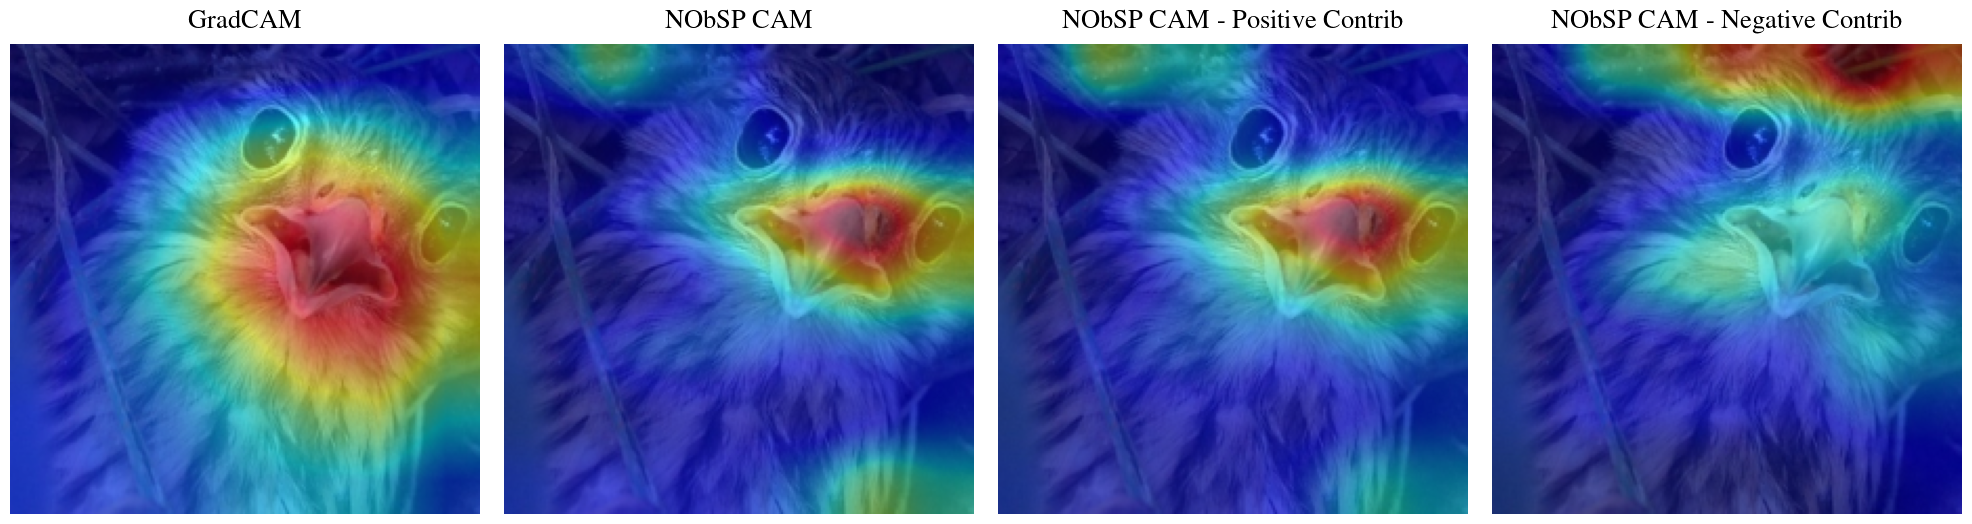

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=200)

ax[0].imshow(cam_image)
ax[0].axis('off')
ax[0].set_title("GradCAM")

ax[1].imshow(input_numpy)
ax[1].imshow(overlay_avg, alpha=0.5)
ax[1].set_title("NObSP CAM")
ax[1].axis('off')

ax[2].imshow(input_numpy)
ax[2].imshow(overlay_pos, alpha=0.5)
ax[2].set_title("NObSP CAM - Positive Contrib")
ax[2].axis('off')

ax[3].imshow(input_numpy)
ax[3].imshow(overlay_neg, alpha=0.5)
ax[3].set_title("NObSP CAM - Negative Contrib")
ax[3].axis('off')

plt.tight_layout()
plt.show()